# 앙상블(ensemble)

## 1. 배깅(bagging)


| 주어진 자료에서 여러 개의 붓스트랩 자료를 생성하고 각각에 예측 모형을 만든 후 결합하고 최종 예측모형을 만드는 방식
* 분산을 줄이고 정확도를 개선하여 과적합을 방지한다.
* 각 붓스트랩에 대해 붓스트래핑 및 모델링 과정에 병렬적으로 수행된다.

[붓스트랩 - 모델링 - 보팅] 의 순서로 진행

**붓스트랩(Bootstrap)**
* 랜덤 샘플링의 일종으로 가설 검증을 하거나 통계 계산을 하기 전에 단순임의복원추출법(중복허용)을 적용하여 여러 개의 동일한 크기의 표본 자료를 획득하는 방법

    주어진 데이터를 모집단을 대표하는 독립 표본으로 가정하고, 무작위 재추출을 하여 복수의 자료를 획득하고 각각의 통게량을 계산

**보팅(Voting)**
* 최적 트리 구축에서 가장 어려운 가지치기를 진행하지 않고 약한 트리를 최대로 성장시킨 후 보팅을 진행


**OOB_score**

* 배깅에서 붓스트래핑 진행 시 평균적으로 훈련데이터의 63%정도만 샘플링
* 이때 선택되지 않은 나머지 37%가 **Out Of Bag** 샘플

    모델의 성능평가 수행 가능 -> 검증세트가 따로 필요하지 않음

In [74]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import *


### 배깅 예제 - 유방암 진단 데이터 (분류)
❗️회귀 모델에서 변수선택법 실습해보기❗️

```from sklearn.ensemble import BaggingClassifier(base_estimator, n_estimators, max_samples, max_features, oob_score)```
* best_estimator: 배깅에서 수행할 분류기. None이면 DecisionTreeClassifier를 수행
* n_estimators: 앙상블의 분류기 모델 수를 설정
* max_samples: 각 기본 추정량을 훈련하기 위해 추출할 샘플의 수 (비율, default=1)
* max_features: 하나의 예측기가 가져갈 수 있는 최대 변수의 수
* oob_score: 일반화 오류 추정을 위한 oob 샘플 사용 여부

In [75]:
breast = pd.read_csv('https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/breast-cancer.csv')
breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [76]:
# 결측치
breast.isna().sum().loc[breast.isna().sum()!=0]

Series([], dtype: int64)

In [77]:
# 이상치
breast.duplicated().sum()

0

In [78]:
breast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [79]:
# 타겟 분포 확인 (M: 악성, B: 양성)
breast.diagnosis.value_counts(normalize=True)

diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64

In [80]:
# 인코딩
breast.diagnosis = np.where(breast.diagnosis == 'M', 1, 0)


In [81]:
corr = breast.drop('id', axis=1) # 고유값 제외하고 상관계수 확인

pos_corr = corr.corr(method='spearman').sort_values('diagnosis', ascending=False)[:10]
neg_corr = corr.corr(method='spearman').sort_values('diagnosis')[:5]

In [82]:
pos_corr

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.732785,0.461971,0.748496,0.734122,0.371892,0.609288,0.733308,0.777877,0.332567,...,0.787933,0.476720,0.796319,0.786902,0.425513,0.606810,0.705734,0.781674,0.396843,0.311477
perimeter_worst,0.796319,0.971555,0.375273,0.978980,0.971822,0.226345,0.592254,0.722424,0.813960,0.190526,...,0.993548,0.381022,1.000000,0.992433,0.241172,0.613070,0.700572,0.812983,0.281383,0.179003
radius_worst,0.787933,0.978604,0.366547,0.981244,0.979258,0.203453,0.542626,0.682316,0.787411,0.164552,...,1.000000,0.371230,0.993548,0.998891,0.218616,0.558316,0.655942,0.780632,0.257165,0.127449
area_worst,0.786902,0.978863,0.368335,0.980864,0.980264,0.191735,0.531590,0.676628,0.780395,0.154462,...,0.998891,0.372376,0.992433,1.000000,0.210063,0.550007,0.651120,0.773945,0.248358,0.118734
concave points_worst,0.781674,0.727265,0.319235,0.757526,0.723390,0.498868,0.825473,0.904938,0.937075,0.397477,...,0.780632,0.365309,0.812983,0.773945,0.543982,0.844454,0.902301,1.000000,0.460711,0.516664
concave points_mean,0.777877,0.759702,0.306891,0.788629,0.755165,0.565172,0.848295,0.927352,1.000000,0.423767,...,0.787411,0.300562,0.813960,0.780395,0.490035,0.758309,0.827281,0.937075,0.355477,0.421110
perimeter_mean,0.748496,0.997802,0.348142,1.000000,0.997068,0.182923,0.543925,0.681958,0.788629,0.150049,...,0.981244,0.323109,0.978980,0.980864,0.156611,0.534565,0.632106,0.757526,0.199007,0.088961
area_mean,0.734122,0.999602,0.344145,0.997068,1.000000,0.138053,0.488988,0.642557,0.755165,0.113928,...,0.979258,0.318178,0.971822,0.980264,0.119712,0.485813,0.593736,0.723390,0.170860,0.038758
concavity_mean,0.733308,0.645728,0.342646,0.681958,0.642557,0.518511,0.896518,1.000000,0.927352,0.446793,...,0.682316,0.335866,0.722424,0.676628,0.488775,0.849985,0.938543,0.904938,0.383667,0.541838
radius_mean,0.732785,1.000000,0.340956,0.997802,0.999602,0.148510,0.497578,0.645728,0.759702,0.120242,...,0.978604,0.314911,0.971555,0.978863,0.125789,0.491357,0.596043,0.727265,0.174698,0.044564


In [83]:
neg_corr.iloc[:, 0]

symmetry_se              -0.092303
smoothness_se            -0.052193
fractal_dimension_mean   -0.025903
texture_se                0.019419
fractal_dimension_se      0.201492
Name: diagnosis, dtype: float64

In [84]:
def metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    rc = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f'''
          혼동행렬 {cm}
          recall: {rc}
          f1_score: {f1}''')
    

In [85]:
# 상관관계가 높은 변수 10개 선택
x = breast[pos_corr.index[1:]]
y = breast.diagnosis
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=1, stratify=y)
# 학습
clf = BaggingClassifier(n_estimators=30, oob_score=True, max_samples=.9)
clf.fit(x_train, y_train)
# 학습 성능 -> 혼동행렬 recall f1
y_pred = clf.predict(x_train)
metrics(y_train, y_pred)




          혼동행렬 [[250   0]
 [  1 147]]
          recall: 0.9932432432432432
          f1_score: 0.9966101694915254


In [86]:
# oob_score 확인
print(f'oob_score: {clf.oob_score_}')
# 일반화 성능 확인
rc_t = recall_score(y_test, clf.predict(x_test))
f1_t = f1_score(y_test, clf.predict(x_test))
print(f'''
      일반화 성능
      
      recall: {rc_t}
      f1: {f1_t}''')


oob_score: 0.9271356783919598

      일반화 성능
      
      recall: 0.875
      f1: 0.9180327868852458


### 배깅 예제 - 자동차 데이터 셋(회귀)

In [87]:
car = pd.read_csv('https://raw.githubusercontent.com/ADPclass/ADP_book_ver01/main/data/CarPrice_Assignment.csv')
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [88]:
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


* ```df.select_dtypes()```

<img src='./imgs/df.select_dtypes.png' width=600px height=170px></img>



In [89]:
# 연속형 변수 분류
car_num = car.select_dtypes(['number'])
X = car_num.drop('price', axis=1)
y = car_num['price']


In [90]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# 모델 인스턴스 생성
reg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=30, oob_score=True)
# 학습
reg.fit(X, y)
# oob 성능(r2)
print(f'oob_score: {reg.oob_score_}')


oob_score: 0.927269585048189


## 2. 부스팅(Boosting)
| 예측력이 약한 모형들을 결합해 강한 예측모형을 만드는 방법으로, 배깅과 달리 순차방식으로 학습을 진행함

훈련 단계에서 데이터 샘플에 가중치를 할당하여 **결과가 좋지 않은 데이터는 높은 가중치**를, **결과가 좋은 데이터는 낮은 가중치**를 할당 받음

높은 가중치를 받은 데이터 샘플은 다음 붓스트래핑에서 추출될 확률이 높아짐 -> 직전 단계에서 **예측력이 약했던 부분을 다음 단계에서 개선**해 나가는 개념

* 배깅에 비해 모델의 장점을 최적화하고 train 데이터에 대해 오류가 적은 모델을 생성할 수 있다는 장점과 동시에 과적합의 우려가 있다




### 부스팅 예제 - 유방암 데이터(분류)

In [91]:
from sklearn.ensemble import AdaBoostClassifier
# 전체 변수로 학습 후 변수 중요도 확인
# 데이터 분할
X = breast.drop(['id', 'diagnosis'], axis=1)
y = breast['diagnosis']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, stratify=y, random_state=1)
## 학습
clf_boost = AdaBoostClassifier(random_state=1)
clf_boost.fit(x_train, y_train)
## 예측
pred = clf_boost.predict(x_train)
## 성능
metrics(y_train, pred)



          혼동행렬 [[250   0]
 [  0 148]]
          recall: 1.0
          f1_score: 1.0


In [92]:
importance = pd.DataFrame(clf_boost.feature_importances_)
col = pd.DataFrame(list(x_train))
feature_imp = pd.concat([col, importance], axis=1)
feature_imp.columns = ['feature', 'importance']
feature_imp = feature_imp.sort_values('importance', ascending=False)


In [93]:
# 변수 선택 후 재학습 (중요도 > 0.1)
x_train = x_train[feature_imp.iloc[:3,0].values]
x_test = x_test[feature_imp.iloc[:3,0].values]
clf_boost_ = AdaBoostClassifier(random_state=1)
clf_boost.fit(x_train, y_train)

# 학습 성능
pred_tr = clf_boost.predict(x_train)
metrics(y_train, pred_tr)
# 일반화 성능
pred_tt = clf_boost.predict(x_test)
metrics(y_test, pred_tt)


          혼동행렬 [[250   0]
 [  0 148]]
          recall: 1.0
          f1_score: 1.0

          혼동행렬 [[104   3]
 [ 11  53]]
          recall: 0.828125
          f1_score: 0.8833333333333333


* ROC curve 시각화

    ```plot_roc_curve(model, x, y)```

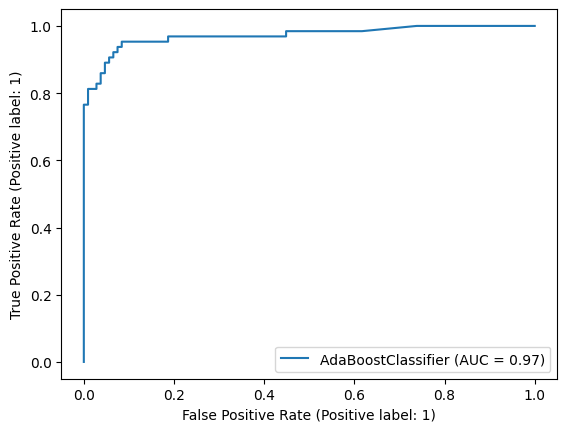

In [94]:
# ROC 커브를 시각화하여 AUC 구하기
import matplotlib.pyplot as plt
RocCurveDisplay.from_estimator(clf_boost, x_test, y_test);

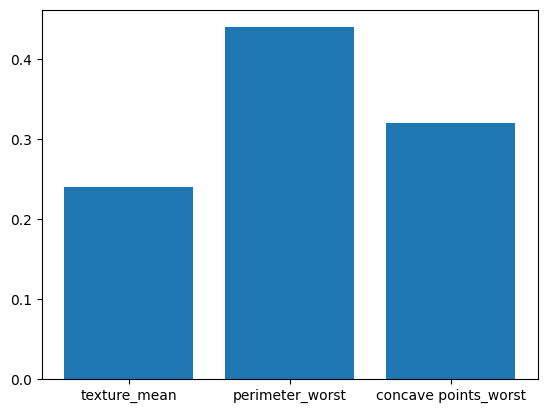

In [95]:

# 변수중요도 시각화하기

importances = clf_boost.feature_importances_
col = list(x_test)
plt.bar(col, importances); # plt.bar(x,y)

### 부스팅 예제 - 자동차 데이터 (회귀)

In [96]:
X = car_num.drop('price', axis=1)
y = car_num['price']
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=1)

In [97]:
def reg_metrics(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    print(f'''
          r2: {r2}
          rmse: {rmse}
          ''')

In [98]:
from sklearn.ensemble import AdaBoostRegressor
# 모델 인스턴스
reg_boost = AdaBoostRegressor()
# 학습
reg_boost.fit(x_train, y_train)
# 예측
pred_tr = reg_boost.predict(x_train)
pred_tt = reg_boost.predict(x_test)
# 성능지표 확인
print('훈련 성능')
reg_metrics(y_train, pred_tr)
print('일반화 성능')
reg_metrics(y_test, pred_tt)

훈련 성능

          r2: 0.9618330895436733
          rmse: 1570.255972902195
          
일반화 성능

          r2: 0.8986394891261704
          rmse: 2473.701047755032
          


* 가로 바차트

```plt.barh(width=x, y=y)```

* df

    ```pd.DataFrame({'col1': [], 'col2': [], 'col3':[]}, columns=['col1', 'col2', 'col3'])```

In [99]:
# 변수중요도 시각화
importance_df = pd.DataFrame({'feature':list(x_train), 'importance':reg_boost.feature_importances_.tolist()}, columns=['feature', 'importance'])
importance_df.sort_values('importance', inplace=True)
importance_df.reset_index(drop=True, inplace=True)
importance_df

,feature,importance
0,symboling,0.000292
1,car_ID,0.002247
2,compressionratio,0.003030
3,carheight,0.003721
4,citympg,0.006983
5,peakrpm,0.007450
6,stroke,0.008736
7,carlength,0.009305
8,boreratio,0.017272
9,wheelbase,0.024954


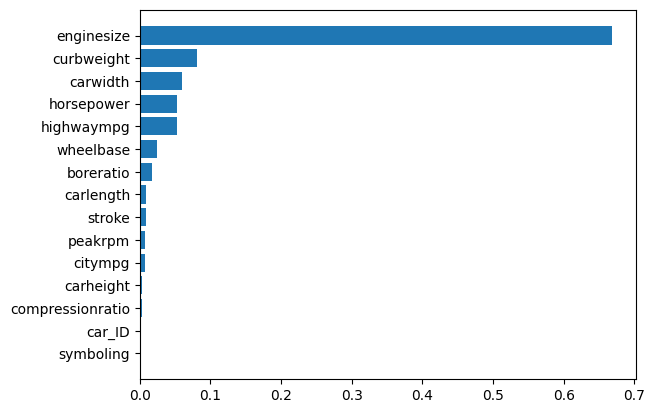

In [100]:
plt.barh(width=importance_df['importance'], y =importance_df['feature']);

## 3. 랜덤포레스트
| 배깅과 부스팅보다 더 많은 무작위성을 주어 약한 학습기들을 생성한 후 이를 선형결합하여 최종 학습기를 만드는 방법

* 수천 개의 변수를 변수 제거 없이 모델링하므로 정확도 측면에서 좋은 성과를 보이는 기법 중 하나
* 이론적 설명이나 최종 결과 해석이 어렵다는 단점이 있지만 예측력이 매우 높음



### 랜덤포레스트 예제 - 유방암 데이터 (분류)

In [101]:
from sklearn.ensemble import RandomForestClassifier
breast.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [102]:
# 변수 전체 학습 후 변수 중요도 확인
x = breast.drop('diagnosis', axis=1)
y = breast['diagnosis']
# 데이터 분할
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=1, stratify=y)

# 인스턴스 생성
rf = RandomForestClassifier(min_samples_split=4)
# 학습
rf.fit(x_train, y_train)
# 예측
pred_tr = rf.predict(x_train)
# 성능
metrics(y_train, pred_tr)


          혼동행렬 [[250   0]
 [  1 147]]
          recall: 0.9932432432432432
          f1_score: 0.9966101694915254


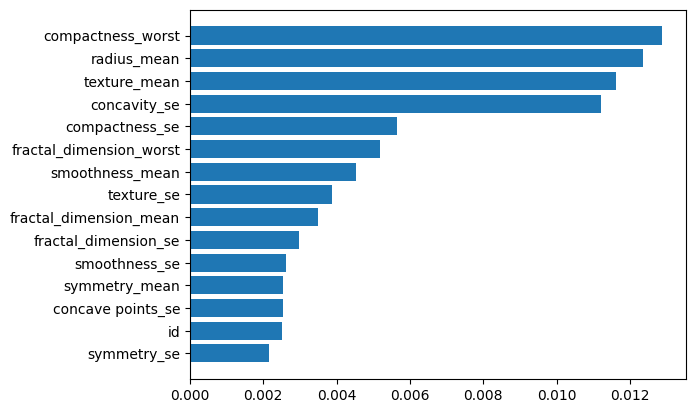

In [103]:
# 변수중요도 시각화
importances = rf.feature_importances_.tolist()
col = list(x_train)
import_df = pd.DataFrame({'feature': col, 'importance': importances}, columns=['feature', 'importance'])
import_df.sort_values('importance', inplace=True)
import_df.reset_index(drop=True, inplace=True)

plt.barh(width=import_df['importance'][:15], y=import_df['feature'][:15]);

In [104]:
# 변수 중요도 > 0.005 인 변수만 선택
cols = import_df.loc[import_df['importance'] > 0.05]['feature'].values
x_train = x_train[cols]

# 재학습
rf.fit(x_train, y_train)
# 예측
pred_tr = rf.predict(x_train)
# 성능
metrics(y_train, pred_tr)


          혼동행렬 [[250   0]
 [  0 148]]
          recall: 1.0
          f1_score: 1.0


* 변수 선택했음에도 성능 동일 - randomforest 특징?

In [105]:
# 하이퍼 파라미터 튜닝 (랜덤cv, 그리드cv) 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_distributions = {
    'max_depth': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(2, 10),
    'min_samples_split': np.arange(2, 10),
    'max_features': np.arange(3, 8)
}
rd_rf = RandomizedSearchCV(rf, param_distributions=param_distributions, cv=5, n_iter=30, random_state=1)
rd_rf.fit(x_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(min_samples_split=4),
                   n_iter=30,
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'max_features': array([3, 4, 5, 6, 7]),
                                        'min_samples_leaf': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9])},
                   random_state=1)

In [106]:
rd_rf.best_estimator_

RandomForestClassifier(max_depth=14, max_features=6, min_samples_leaf=4,
                       min_samples_split=6)

In [107]:
# GridSearch
rf = RandomForestClassifier(max_features=3)
param_grid = {
    'max_depth': np.arange(10, 15),
    'min_samples_leaf': np.arange(7, 11),
    'min_samples_split': np.arange(2, 6),
}
gr_rf = GridSearchCV(rf, cv=5, param_grid=param_grid)
gr_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(max_features=3),
             param_grid={'max_depth': array([10, 11, 12, 13, 14]),
                         'min_samples_leaf': array([ 7,  8,  9, 10]),
                         'min_samples_split': array([2, 3, 4, 5])})

In [108]:
gr_rf.best_params_

{'max_depth': 14, 'min_samples_leaf': 10, 'min_samples_split': 3}

In [115]:
# 최종 모델 학습성능
model = gr_rf.best_estimator_
pred_tr = model.predict(x_train)
print('학습 성능')
metrics(y_train, pred_tr)
# 일반화 성능
pred_tt = model.predict(x_test[cols])
print('일반화 성능')
metrics(y_test, pred_tt)

학습 성능

          혼동행렬 [[242   8]
 [  8 140]]
          recall: 0.9459459459459459
          f1_score: 0.9459459459459459
일반화 성능

          혼동행렬 [[105   2]
 [  8  56]]
          recall: 0.875
          f1_score: 0.9180327868852458


* ❗️```plot_roc_curve```는 sklearn 이전 버전에서 사용❗️

    -> ```RocCurveDisplay.from_estimator(model, x, y)```로 작성 

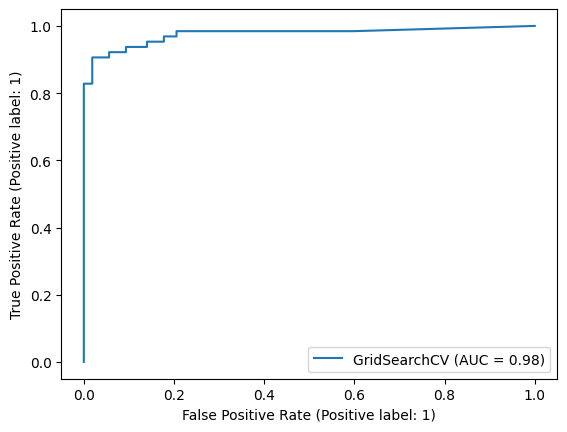

In [110]:
# ROC_CURVE
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(gr_rf, x_test[cols], y_test)
plt.show();

### 랜덤포레스트 예제 - 자동차데이터(회귀)

In [111]:
car.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


In [112]:
col = car.dtypes.loc[car.dtypes == 'object'].index
car_obj = car[col]
car_obj.head()

,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem
0,alfa-romero giulia,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,alfa-romero stelvio,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,audi 100 ls,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,audi 100ls,gas,std,four,sedan,4wd,front,ohc,five,mpfi


In [113]:
# 범주형 변수 인코딩 (OneHot, Ordinal)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
ohe = OneHotEncoder()
ord = OrdinalEncoder()

In [114]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()